In [1]:
import tmdbsimple as tmdb
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

In [2]:
from my_secrets import TMDB_API_KEY

In [3]:
tmdb.API_KEY = TMDB_API_KEY

# Function to get movie details from TMDb
def get_movie_details(company_id, num_movies=10):
    company = tmdb.Companies(company_id)
    movies = company.movies()['results'][:num_movies]
    movie_details = []
    for movie in movies:
        movie_info = tmdb.Movies(movie['id']).info()
        movie_details.append({
            'title': movie_info['title'],
            'release_date': movie_info['release_date'],
            'description': movie_info['overview']
        })
    return pd.DataFrame(movie_details)

# Example: Collecting movie details for Walt Disney Pictures (company ID: 2)
movie_data = get_movie_details(company_id=2)

In [4]:
movie_data

,title,release_date,description
0,Inside Out 2,2024-06-11,Teenager Riley's mind headquarters is undergoi...
1,Inside Out,2015-06-09,From an adventurous balloon ride above the clo...
2,Wish,2023-11-13,"Asha, a sharp-witted idealist, makes a wish so..."
3,Elemental,2023-06-14,"In a city where fire, water, land and air resi..."
4,Turning Red,2022-03-10,Thirteen-year-old Mei is experiencing the awkw...
5,Coco,2017-10-27,Despite his family’s baffling generations-old ...
6,Encanto,2021-10-13,"The tale of an extraordinary family, the Madri..."
7,WALL·E,2008-06-22,"In the distant future, Earth has become a deso..."
8,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,"Jack Sparrow, a freewheeling 18th-century pira..."
9,"The Chronicles of Narnia: The Lion, the Witch ...",2005-12-07,"Siblings Lucy, Edmund, Susan and Peter step th..."


In [5]:
# Function to get stock data from Yahoo Finance
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Example: Collecting stock data for Disney (ticker: DIS)
# Collect stock data for 5 days before and 5 days after each movie release date
def get_stock_data_around_release_dates(movie_data, ticker, days_before=15, days_after=15):
    stock_data_list = []
    for release_date in movie_data['release_date']:
        release_date = datetime.datetime.strptime(release_date, '%Y-%m-%d')
        start_date = (release_date - datetime.timedelta(days=days_before)).strftime('%Y-%m-%d')
        end_date = (release_date + datetime.timedelta(days=days_after)).strftime('%Y-%m-%d')
        stock_data = get_stock_data(ticker, start_date, end_date)
        stock_data['release_date'] = release_date.strftime('%Y-%m-%d')
        stock_data_list.append(stock_data)
    return pd.concat(stock_data_list)

# Example: Getting stock data around movie release dates
stock_data = get_stock_data_around_release_dates(movie_data, ticker='DIS')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,release_date
Date,,,,,,,
2024-05-28,101.360001,102.860001,100.949997,102.440002,102.440002,7813100,2024-06-11
2024-05-29,101.760002,102.080002,100.769997,100.879997,100.879997,7376300,2024-06-11
2024-05-30,101.139999,102.070000,100.970001,101.699997,101.699997,7303700,2024-06-11
2024-05-31,101.519997,104.080002,101.410004,103.910004,103.910004,14735800,2024-06-11
2024-06-03,104.169998,104.220001,102.480003,102.769997,102.769997,6908600,2024-06-11
...,...,...,...,...,...,...,...
2005-12-15,24.662500,24.751286,24.376415,24.406010,20.234562,8148403,2005-12-07
2005-12-16,24.563850,24.573715,24.208710,24.366550,20.201845,16276939,2005-12-07
2005-12-19,23.991680,24.514524,23.991680,24.208710,20.070984,6916675,2005-12-07


In [7]:
stock_data["release_date"].value_counts()


release_date
2022-03-10    22
2017-10-27    22
2021-10-13    22
2015-06-09    21
2023-06-14    21
2003-07-09    21
2005-12-07    21
2023-11-13    20
2008-06-22    19
2024-06-11    13
Name: count, dtype: int64

In [20]:
stock_data.reset_index(inplace=True)

In [25]:
def merge_movie_and_stock_data(movie_data, stock_data):
    movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])
    stock_data['release_date'] = pd.to_datetime(stock_data['release_date'])
    merged_data = pd.merge(stock_data.sort_values('release_date'), movie_data.sort_values('release_date'), left_on='release_date', right_on='release_date')
    return merged_data


In [26]:
# Example: Merging data
merged_data = merge_movie_and_stock_data(movie_data, stock_data)

In [27]:
merged_data

,Date,Open,High,Low,Close,Adj Close,Volume,release_date,title,description
0,2003-07-11,20.282440,20.598120,20.282440,20.558661,16.558733,5254840,2003-07-09,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 18th-century pira..."
1,2003-07-23,20.548796,20.637581,20.025949,20.331764,16.375988,5912114,2003-07-09,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 18th-century pira..."
2,2003-07-22,20.223249,20.755960,20.075275,20.538931,16.542847,7360061,2003-07-09,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 18th-century pira..."
3,2003-07-21,20.519199,20.558661,19.986490,20.134464,16.217072,6987329,2003-07-09,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 18th-century pira..."
4,2003-07-18,20.686905,20.765825,20.460011,20.726364,16.693810,5585099,2003-07-09,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 18th-century pira..."
...,...,...,...,...,...,...,...,...,...,...
197,2024-06-10,101.250000,102.849998,100.639999,102.739998,102.739998,7633100,2024-06-11,Inside Out 2,Teenager Riley's mind headquarters is undergoi...
198,2024-06-12,101.199997,101.690002,100.250000,100.800003,100.800003,9028800,2024-06-11,Inside Out 2,Teenager Riley's mind headquarters is undergoi...
199,2024-06-13,100.610001,101.070000,99.730003,99.769997,99.769997,4110092,2024-06-11,Inside Out 2,Teenager Riley's mind headquarters is undergoi...
200,2024-06-05,103.000000,103.080002,101.029999,101.500000,101.500000,10796900,2024-06-11,Inside Out 2,Teenager Riley's mind headquarters is undergoi...


In [28]:
merged_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'release_date', 'title', 'description'],
      dtype='object')

In [29]:
# Sentiment Analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Example: Sentiment analysis on movie descriptions
movie_data['sentiment'] = movie_data['description'].apply(analyze_sentiment)

In [30]:
movie_data['sentiment']

0    0.196307
1    0.383333
2    0.152083
3    0.034091
4    0.125000
5    0.123611
6    0.216942
7   -0.005000
8    0.500000
9    0.350000
Name: sentiment, dtype: float64

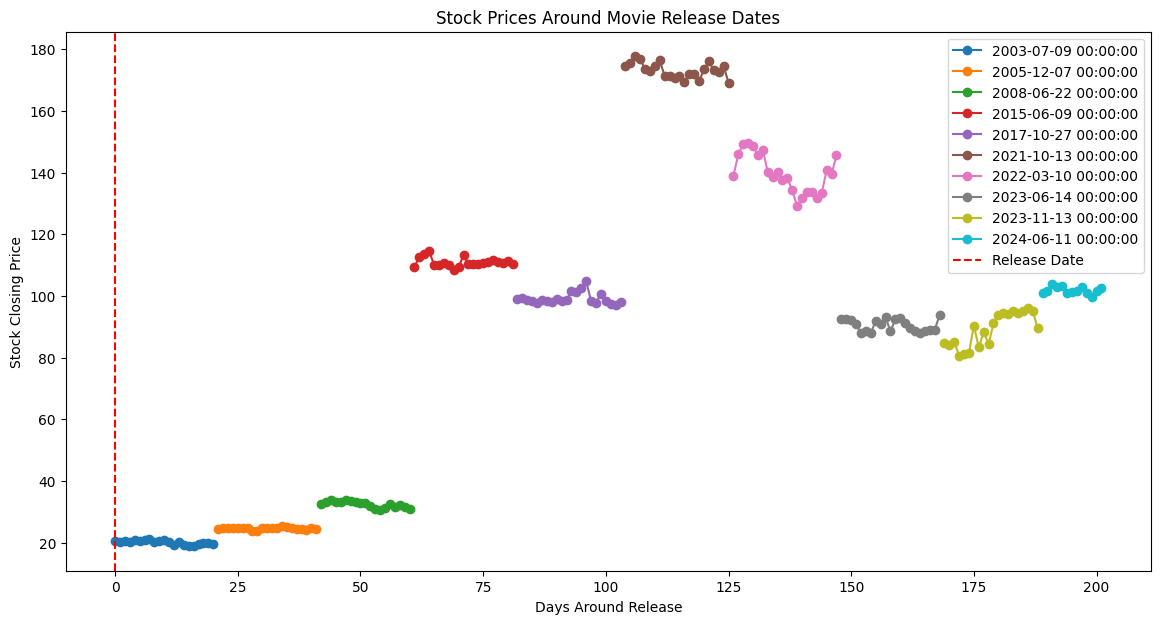

In [31]:
# Data Visualization
def plot_stock_prices_around_release(merged_data):
    plt.figure(figsize=(14, 7))
    for release_date in merged_data['release_date'].unique():
        subset = merged_data[merged_data['release_date'] == release_date]
        plt.plot(subset.index, subset['Close'], marker='o', label=release_date)
    plt.axvline(x=0, color='red', linestyle='--', label='Release Date')
    plt.xlabel('Days Around Release')
    plt.ylabel('Stock Closing Price')
    plt.title('Stock Prices Around Movie Release Dates')
    plt.legend()
    plt.show()

# Example: Plotting stock prices
plot_stock_prices_around_release(merged_data)

In [37]:
pd.DataFrame(merged_data.groupby('release_date').value_counts())

count
release_date Date       Open       High       Low        Close      Adj Close  Volume   title                                              description                                              
2003-07-09   2003-06-24 19.591890  19.660946  19.226885  19.364994  15.597313  7900456  Pirates of the Caribbean: The Curse of the Blac... Jack Sparrow, a freewheeling 18th-century pirat...      1
             2003-06-25 19.443914  19.483376  18.743500  18.852015  15.184139  13572529 Pirates of the Caribbean: The Curse of the Blac... Jack Sparrow, a freewheeling 18th-century pirat...      1
             2003-06-26 18.881611  19.207155  18.595526  19.138100  15.414562  8247745  Pirates of the Caribbean: The Curse of the Blac... Jack Sparrow, a freewheeling 18th-century pirat...      1
             2003-06-27 19.286076  19.414320  18.970394  19.078911  15.366886  6626457  Pirates of the Caribbean: The Curse of the Blac... Jack Sparrow, a freewheeling 18th-century pirat...      1
             2003-06-30 19.730000  19.897705  19.276211  19.483376  15.692662  14831424 Pirates of the Caribbean: The Curse of the Blac... Jack Sparrow, a freewheeling 18th-century pirat...      1
...                                                                                                                                                                                              ...
2024-06-11   2024-06-07 100.860001 102.269997 100.550003 101.540001 101.540001 6047800  Inside Out 2                                       Teenager Riley's mind headquarters is undergoin...      1
             2024-06-10 101.250000 102.849998 100.639999 102.739998 102.739998 7633100  Inside Out 2                                       Teenager Riley's mind headquarters is undergoin...      1
             2024-06-11 102.639999 102.879997 100.739998 100.870003 100.870003 9134200  Inside Out 2                                       Teenager Riley's mind headquarters is undergoin...      1
             2024-06-12 101.199997 101.690002 100.250000 100.800003 100.800003 9028800  Inside Out 2                                       Teenager Riley's mind headquarters is undergoin...      1
             2024-06-13 100.610001 101.070000 99.730003  99.769997  99.769997  4110092  Inside Out 2                                       Teenager Riley's mind headquarters is undergoin...      1

[202 rows x 1 columns]

In [39]:
pd.DataFrame(merged_data.groupby('release_date').value_counts()).query("release_date == '2003-07-09'").shape

(21, 1)